In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """Cleans the input text by removing special characters and stopwords."""
    if isinstance(text, str):  # Proceed only if the text is a string
        text = text.lower()  # Lowercase the text
        text = REPLACE_BY_SPACE_RE.sub(' ', text)  # Replace unwanted symbols with space
        text = BAD_SYMBOLS_RE.sub('', text)  # Remove unwanted symbols
    return text  # Return the cleaned text (or the original if not a string)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class(df):
    """Plots the count of each class in the dataset."""
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='Class', order=df['Class'].value_counts().index)
    plt.title('Count of Each Class')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [4]:
def load_data(data_file):
    df = pd.read_csv(data_file)
    specified_tags = ['Class A', 'Class B', 'Class C', 'Class D']
    df = df.dropna(subset=['Name of Device', 'Intended Use'])
    df['merged']=df['Name of Device']+' '+df['Intended Use']
    df = df.dropna(subset=['merged', 'Class'])
    df = df[df['Class'].isin(specified_tags)]
    df['merged'] = df['merged'].apply(clean_text)
    plot_class(df)
    texts=df['merged'].tolist()
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['Class'])
    return texts, labels

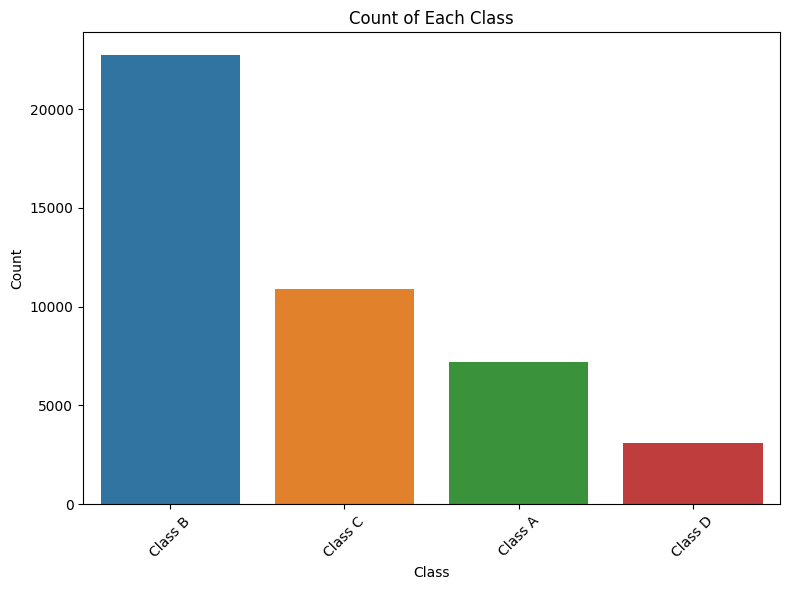

In [5]:
data_file = "/kaggle/input/mdc-fine/ImageGen.csv"
texts, labels = load_data(data_file)

In [6]:
print(len(texts))

43933


In [7]:
from transformers import AutoTokenizer, AutoModel

In [8]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [9]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert =  AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            return logits

In [10]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model.forward(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [11]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model.forward(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions, zero_division = 0)

In [12]:
# Set up parameters
bert_model_name = 'emilyalsentzer/Bio_ClinicalBERT'
num_classes = 4
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [13]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [14]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [16]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4


In [ ]:
torch.save(model.state_dict(), "bert_classifier_best_version.pth")